Requirements

```
pip install seaborn jupyter cached-property
```

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from cached_property import cached_property
from pathlib import Path
import os
import dateutil
import numpy as np

plt.rcParams['figure.figsize'] = [15, 15]
sns.set()

# Handle date time conversions between pandas and matplotlib
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

In [9]:
class Universe:
    
    def __init__(self, data):
        self.data = data
        self.excluded_columns = set([
            'date',
            'Recovered',
            'Diamond Princess'
        ])

    @staticmethod
    def _date_columns(df):
        return sorted(
            [col for col in df.columns.unique() if col[0].isnumeric()],
            key=lambda col: dateutil.parser.parse(col)
        )
    
    @staticmethod
    def _date_columns_as_dates(df):
        return [
            dateutil.parser.parse(col) for col in Universe._date_columns(df)
        ]
    
    @cached_property
    def _date_formatter(self):
        return matplotlib.dates.DateFormatter('%m.%d')
    
    @cached_property
    def states(self):
        states_cases = sorted(self.cases_by_state.columns.unique())
        states_deaths = sorted(self.deaths_by_state.columns.unique())
        assert states_cases == states_deaths
        return sorted(
            list(
                set(states_cases) - self.excluded_columns
            )
        )
    
    @cached_property
    def countries(self):
        countries_cases = sorted(self.cases_by_country.columns.unique())
        countries_deaths = sorted(self.deaths_by_country.columns.unique())
        assert countries_cases == countries_deaths
        return sorted(
            list(
                set(countries_cases) - self.excluded_columns
            )
        )

    @staticmethod
    def _pivot(df, index):
        df = pd.pivot_table(
            df,
            index=index,
            values=Universe._date_columns(df),
            aggfunc=np.sum
        )
        df = df[Universe._date_columns(df)]
        df = df.rename(columns={
            str_date: date_date
            for str_date, date_date
            in zip(
                Universe._date_columns(df), Universe._date_columns_as_dates(df)
            )
        })
        df = df.transpose()
        df = df.reset_index()
        df = df.rename(columns={'index': 'date'})
        return df
    
    @staticmethod
    def _plot_data_total(df, col):
        return {
            'x': df.date,
            'y': df[col]
        }
    
    @staticmethod
    def _plot_data_daily(df, col):
        return {
            'x': df.date[1:],
            'y': np.diff(df[col])
        }
    
    @cached_property
    def cases_by_state(self):
        return self._pivot(self.data['cases_us'], 'Province_State')
    
    @cached_property
    def deaths_by_state(self):
        return self._pivot(self.data['deaths_us'], 'Province_State')
    
    @cached_property
    def cases_by_country(self):
        return self._pivot(self.data['cases_global'], 'Country/Region')
    
    @cached_property
    def deaths_by_country(self):
        return self._pivot(self.data['deaths_global'], 'Country/Region')
    
    def plot_total_deaths_by_state(self, state):
        self._plot_total_deaths(self.deaths_by_state, state)
    
    def plot_daily_deaths_by_state(self, state):
        self._plot_daily_deaths(self.deaths_by_state, state)

    def plot_total_cases_by_state(self, state):
        self._plot_total_cases(self.cases_by_state, state)
    
    def plot_daily_cases_by_state(self, state):
        self._plot_daily_cases(self.cases_by_state, state)
    
    def plot_total_deaths_by_country(self, country):
        self._plot_total_deaths(self.deaths_by_country, country)
    
    def plot_daily_deaths_by_country(self, country):
        self._plot_daily_deaths(self.deaths_by_country, country)
    
    def plot_total_cases_by_country(self, country):
        self._plot_total_cases(self.cases_by_country, country)
    
    def plot_daily_cases_by_country(self, country):
        self._plot_daily_cases(self.cases_by_country, country)

    def _plot_daily_deaths(self, df, col):
        ax = sns.lineplot(**self._plot_data_daily(df, col))
        ax.set_title(f'Daily Deaths - {col}')
        ax.set_ylabel('Deaths')
        ax.set_xlabel('')
        ax.xaxis.set_major_formatter(self._date_formatter)
    
    def _plot_total_deaths(self, df, col):
        ax = sns.lineplot(**self._plot_data_total(df, col))
        ax.set_title(f'Daily Deaths - {col}')
        ax.set_ylabel('Deaths')
        ax.set_xlabel('')
        ax.xaxis.set_major_formatter(self._date_formatter)
    
    def _plot_daily_cases(self, df, col):
        ax = sns.lineplot(**self._plot_data_daily(df, col))
        ax.set_title(f'Daily Cases - {col}')
        ax.set_ylabel('Cases')
        ax.set_xlabel('')
        ax.xaxis.set_major_formatter(self._date_formatter)
    
    def _plot_total_cases(self, df, col):
        ax = sns.lineplot(**self._plot_data_total(df, col))
        ax.set_title(f'Total Cases - {col}')
        ax.set_ylabel('Cases')
        ax.set_xlabel('')
        ax.xaxis.set_major_formatter(self._date_formatter)
    
    @classmethod
    def from_repo(cls):
        repo_dir = Path(os.getcwd(), 'COVID-19')
    
        if not repo_dir.exists():
            os.system('git clone https://github.com/CSSEGISandData/COVID-19.git')
        else:
            os.system('cd COVID-19;git pull origin master')

        time_series_dir = Path('COVID-19\\csse_covid_19_data\\csse_covid_19_time_series')

        deaths_us_csv = Path(time_series_dir, 'time_series_covid19_deaths_US.csv')
        cases_us_csv = Path(time_series_dir, 'time_series_covid19_confirmed_US.csv')
        
        deaths_global_csv = Path(time_series_dir, 'time_series_covid19_deaths_global.csv')
        cases_global_csv = Path(time_series_dir, 'time_series_covid19_confirmed_global.csv')
        
        return cls({
            'cases_us': pd.read_csv(cases_us_csv),
            'deaths_us': pd.read_csv(deaths_us_csv),
            'cases_global': pd.read_csv(cases_global_csv),
            'deaths_global': pd.read_csv(deaths_global_csv)
        })
    
universe = Universe.from_repo()

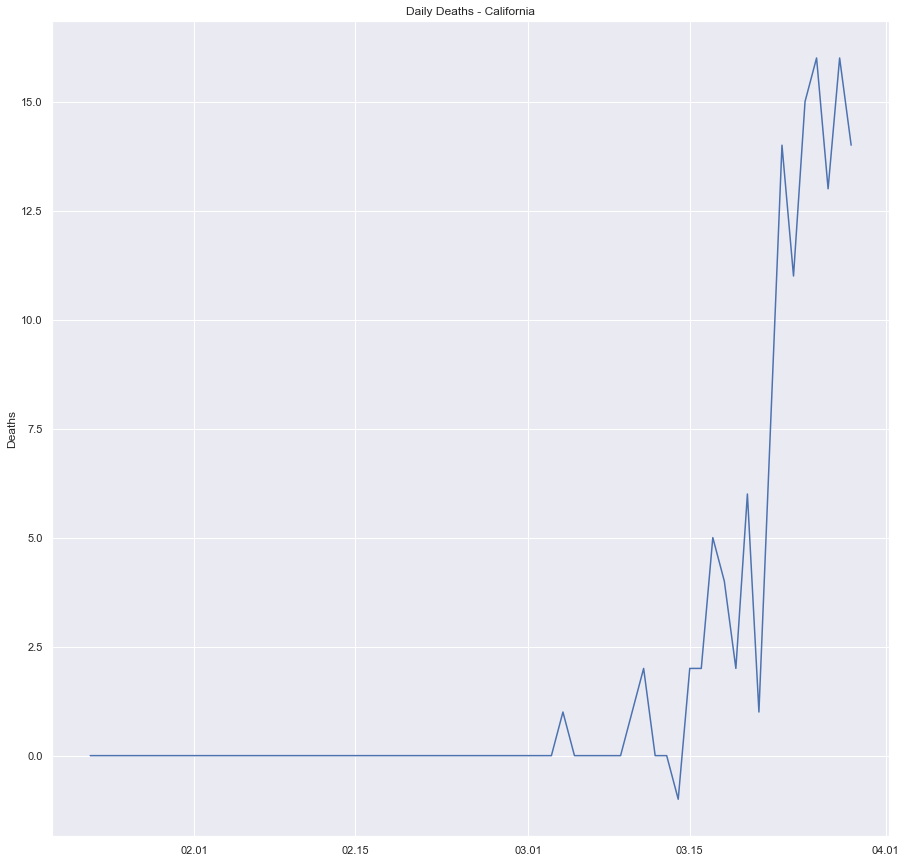

In [10]:
universe.plot_daily_deaths_by_state('California')

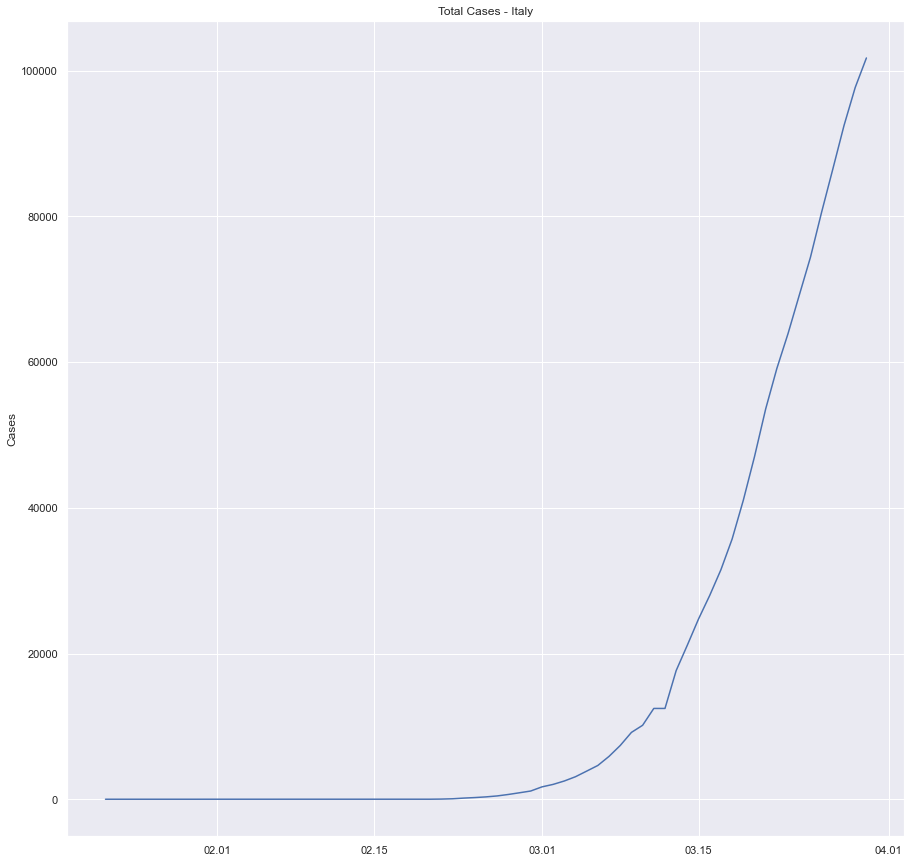

In [11]:
universe.plot_total_cases_by_country('Italy')